# generate 1D test data

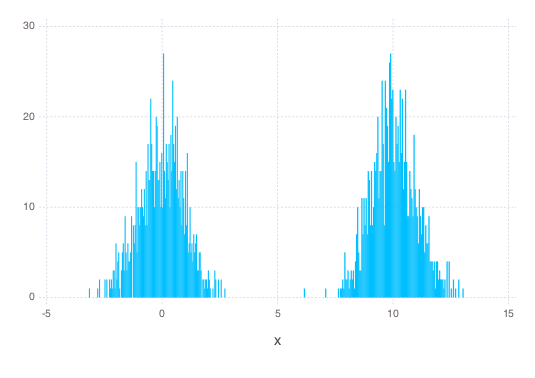

In [1]:
using Gadfly

N = 1000

X = randn(N)
Y = randn(N) + 10

plot(   layer(x = X, Geom.histogram),
layer(x = Y, Geom.histogram))

# construct SPN

In [7]:
#using SPN
using Distributions
include("../src/SPN.jl")

root = SPN.SumNode(0)

SPN.add!(root, SPN.UnivariateNode(fit(Normal, X)))
SPN.add!(root, SPN.UnivariateNode(fit(Normal, Y)))

SPN.normalize!(root);

SPN.order(root)

3-element Array{SPN.SPNNode,1}:
 SPN.UnivariateNode(Distributions.Normal(μ=-0.023625573581675344, σ=0.9612608114107483),0)                                                                                                                                                      
 SPN.UnivariateNode(Distributions.Normal(μ=10.03119464873892, σ=0.9673843565457136),0)                                                                                                                                                          
 SPN.SumNode(0,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=-0.023625573581675344, σ=0.9612608114107483),0),SPN.UnivariateNode(Distributions.Normal(μ=10.03119464873892, σ=0.9673843565457136),0)],Float32[0.6024095f0,0.39759055f0],0)

## test

In [46]:
using Base.Test

N = 100

X = randn(N)

root = SPN.SumNode(0)
SPN.add!(root, SPN.UnivariateNode(fit(Normal, X)))
SPN.normalize!(root);

@test length(root.children) == 1
@test root.weights[1] == 1.0
@test SPN.order(root)[end] == root

In [14]:
@time SPN.order(root);

  0.000064 seconds (38 allocations: 1.531 KB)


In [24]:
SPN.llh(root, [5.0])
@time SPN.llh(root, [5.0]);

  0.000174 seconds (97 allocations: 4.859 KB)


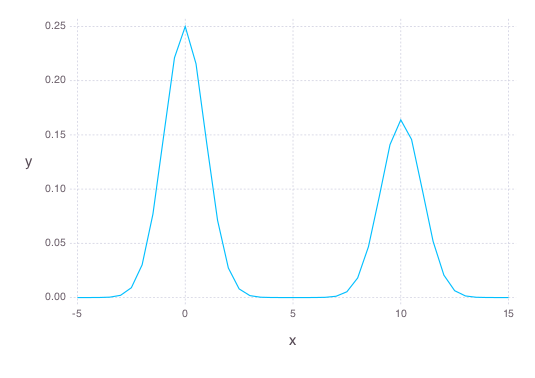

In [26]:
x = -5:0.5:15
p = zeros(length(x))

p = SPN.llh(root, collect(x))

plot( x = x, y = exp(p), Geom.line )

# generate 2D test data

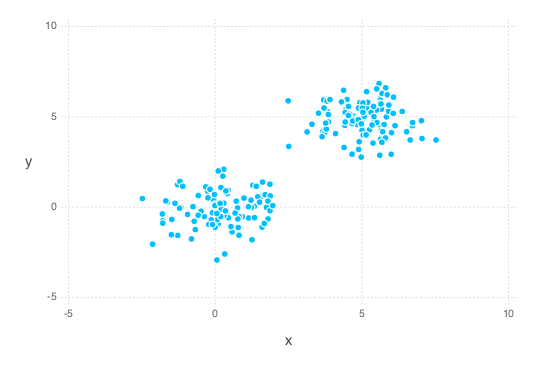

In [27]:
N = 100

X1 = randn(2, N)
X2 = 5 + randn(2, N)

X = cat(2, X1, X2)

plot(x = X[1,:], y = X[2,:], Geom.point)

In [28]:
root = SPN.SumNode(0)

pnode1 = SPN.ProductNode(1)

SPN.add!(pnode1, SPN.UnivariateNode(fit(Normal, X1[1,:]), 1))
SPN.add!(pnode1, SPN.UnivariateNode(fit(Normal, X1[2,:]), 2))

pnode2 = SPN.ProductNode(2)

SPN.add!(pnode2, SPN.UnivariateNode(fit(Normal, X2[1,:]), 1))
SPN.add!(pnode2, SPN.UnivariateNode(fit(Normal, X2[2,:]), 2))

SPN.add!(root, pnode1)
SPN.add!(root, pnode2)

SPN.SumNode(0,SPN.SPNNode[SPN.ProductNode(1,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=0.19210315760048272, σ=1.0555306652796268),1),SPN.UnivariateNode(Distributions.Normal(μ=-0.13861302167889103, σ=0.9459990418842162),2)],Nullable{SPN.ClassNode}()),SPN.ProductNode(2,SPN.SPNNode[SPN.UnivariateNode(Distributions.Normal(μ=5.055864104945226, σ=0.9531384002341028),1),SPN.UnivariateNode(Distributions.Normal(μ=4.849781374805451, σ=0.9203327262354285),2)],Nullable{SPN.ClassNode}())],Float32[0.3836826f0,0.31946814f0],0)

In [29]:
x = [0.0 0.0; 0.3 0.5; 0.4 0.1]'

SPN.llh(root, x)

1x3 Array{Float64,2}:
 -2.46946  -2.67525  -2.49337

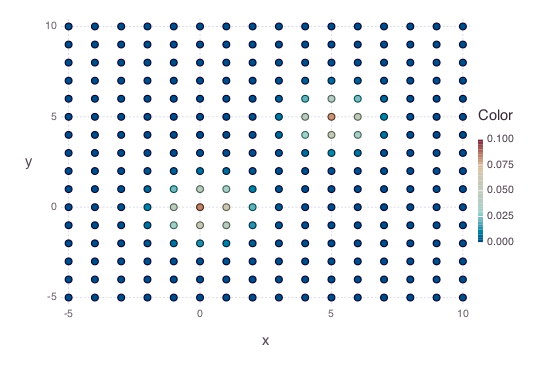

In [30]:
x = -5:10
X = zeros(2, length(x) ^ 2)

for (ii, i) in enumerate(x)
    for (jj, j) in enumerate(x)
        
        ix = ii - 1
        
        X[1,jj + ix*(length(x))] = i
        X[2,jj + ix*(length(x))] = j
    end
end

p = SPN.llh(root, X)

plot(x = X[1,:], y = X[2,:], color=exp(p), Geom.point)

## use multivariate nodes

In [ ]:
using BNP
using Distributions

μ0 = vec( zeros(D) )
κ0 = 1.0
ν0 = convert(Float64, D)
Ψ = eye(D) * 10

d = GaussianWishart(μ0, κ0, ν0, Ψ);

println(SPN.MultivariateNode{ConjugatePostDistribution}(d, collect(1:2)))

# Distributions version

d = MvNormal(zeros(D), eye(D))
n = SPN.MultivariateNode{ContinuousMultivariateDistribution}(d, collect(1:2))

println(n)

SPN.eval(n, zeros(D, 1), Dict{SPN.SPNNode, Array{Float64}}())